In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load Image (Grayscale) 
img = cv2.imread("sample.jpg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Image not found! Place 'image.png' in the same folder.")


In [4]:
#  Create Motion Blur PSF (Degradation Function) ===
def motion_blur_psf(shape, a=0.1, b=0.1, T=1):
    M, N = shape
    U, V = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
    H = T * (np.sinc(a*U + b*V) + 1e-8) * np.exp(-1j*np.pi*(a*U + b*V))
    return np.fft.ifftshift(H)

H = motion_blur_psf(img.shape)


In [5]:
# Fourier transform of original image
F = np.fft.fft2(img)

# Apply degradation
G = H * F

# Add Gaussian noise
noise = np.random.normal(0, 10, img.shape)
G_noisy = G + np.fft.fft2(noise)

# Degraded image
g = np.abs(np.fft.ifft2(G_noisy))

In [6]:
# 3a: Wiener Filter (Constant K) 
K = 0.01  # constant ratio
H_conj = np.conj(H)
W_filter_const = (H_conj / (np.abs(H)**2 + K))
F_hat_const = W_filter_const * G_noisy
f_hat_const = np.abs(np.fft.ifft2(F_hat_const))

In [7]:
# 3b: Wiener Filter (Autocorrelation Estimate)
# Power spectrum of degraded image
S_gg = np.abs(G_noisy)**2
# Noise power spectrum (estimated from added noise)
S_nn = np.abs(np.fft.fft2(noise))**2

# Wiener filter using auto-correlation
W_filter_auto = (H_conj / (np.abs(H)**2 + (S_nn / (S_gg + 1e-8))))
F_hat_auto = W_filter_auto * G_noisy
f_hat_auto = np.abs(np.fft.ifft2(F_hat_auto))

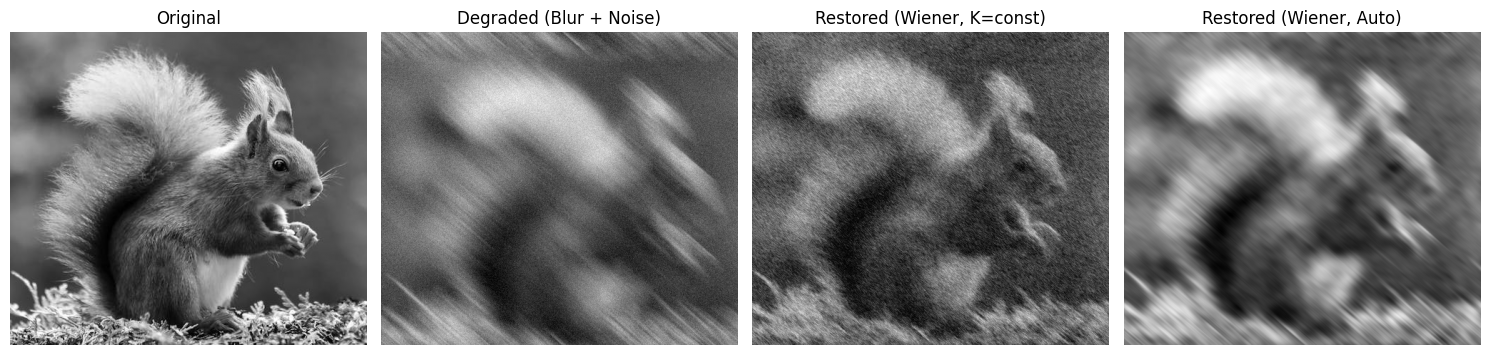

In [8]:
# Display Results
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(g, cmap='gray')
plt.title("Degraded (Blur + Noise)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(f_hat_const, cmap='gray')
plt.title("Restored (Wiener, K=const)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(f_hat_auto, cmap='gray')
plt.title("Restored (Wiener, Auto)")
plt.axis("off")

plt.tight_layout()
plt.show()
